In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs
import Dates as dates 
import payoff as pf

%reload_ext autoreload
%autoreload 2


In [2]:

def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

data


[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120483,237.429871
2023-04-28,546.263367,242.368103
2023-05-02,545.868896,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [3]:
def multi_asset_gbm(data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulation for 1 day and 1 simulation 

    Params:
        fdos : Specified first day of simulation, to be used in pricing 
        data : get data function 
    
    """
    try:
        log_returns_list = []
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker]/data[ticker].shift(1))
            log_returns.dropna(inplace = True) # A series
            log_returns_list.append(log_returns)
        
    except Exception as e:
        raise Exception("Error at generating log return.")


    try: 
        cov_matrix = np.cov(np.array(log_returns_list))
        L = np.linalg.cholesky(cov_matrix)
        
    except Exception as e:
        raise Exception("Error at covariance matrix.")

    try:
        
        date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
        s0_vector_fdos = data.loc[fdos]
        sim_window = dates.num_business_days(fdos, cs.final_fixing_date)
        print(sim_window)
        sim_data = pd.DataFrame(np.zeros((sim_window, cs.num_ticker)), columns = cs.ticker_list)
        Zlist = np.random.normal(0, 1, (cs.num_ticker, sim_window))
        for t in range(sim_window):
            Z = Zlist[:, t]
            LZ = np.dot(L, Z.T)
            print(f"Time step {t}, Z: {Z}, LZ: {LZ}")
            for i in range(cs.num_ticker):
                s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
                print(f"Ticker {cs.ticker_list[i]}, s0_vector_fdos: {s0_vector_fdos[i]}")
                sim_data.loc[t, cs.ticker_list[i]] = s0_vector_fdos[i]

    

    except Exception as e:
        raise Exception("Error at Simulation")
    
    sim_data.index = date_list
    return sim_data




In [4]:

simdata = multi_asset_gbm(data= data, fdos = cs.initial_fixing_date)
simdata

315
Time step 0, Z: [-1.03219787  0.06873515], LZ: [-0.02391502 -0.00528927]
Ticker LONN.SW, s0_vector_fdos: 529.3467056292106
Ticker SIKA.SW, s0_vector_fdos: 236.19412767847692
Time step 1, Z: [-0.52684964  1.1128879 ], LZ: [-0.01220659  0.01152326]
Ticker LONN.SW, s0_vector_fdos: 522.9612586227363
Ticker SIKA.SW, s0_vector_fdos: 238.94856457468236
Time step 2, Z: [1.51118085 1.93908146], LZ: [0.03501259 0.03466029]
Ticker LONN.SW, s0_vector_fdos: 541.6339137473017
Ticker SIKA.SW, s0_vector_fdos: 247.3933592717901
Time step 3, Z: [0.74039319 0.07610147], LZ: [0.01715419 0.00544886]
Ticker LONN.SW, s0_vector_fdos: 551.0441260947183
Ticker SIKA.SW, s0_vector_fdos: 248.76271405218665
Time step 4, Z: [-1.04337783  1.13138204], LZ: [-0.02417405  0.00866658]
Ticker LONN.SW, s0_vector_fdos: 537.9207289174168
Ticker SIKA.SW, s0_vector_fdos: 250.9458256527644
Time step 5, Z: [1.26913299 0.26618884], LZ: [0.02940457 0.01113134]
Ticker LONN.SW, s0_vector_fdos: 554.0118871766273
Ticker SIKA.SW, s

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 130, Z: [0.7087753  0.90005789], LZ: [0.01642163 0.0161322 ]
Ticker LONN.SW, s0_vector_fdos: 741.6331429387621
Ticker SIKA.SW, s0_vector_fdos: 249.40377331318913
Time step 131, Z: [ 0.23479105 -0.26291622], LZ: [ 0.00543988 -0.00206005]
Ticker LONN.SW, s0_vector_fdos: 745.7310018421559
Ticker SIKA.SW, s0_vector_fdos: 248.90819186516495
Time step 132, Z: [-0.35611356 -0.56309033], LZ: [-0.0082508  -0.00956845]
Ticker LONN.SW, s0_vector_fdos: 739.6554776407329
Ticker SIKA.SW, s0_vector_fdos: 246.55539280035677
Time step 133, Z: [0.47421594 1.07915862], LZ: [0.01098712 0.01708759]
Ticker LONN.SW, s0_vector_fdos: 747.879592056165
Ticker SIKA.SW, s0_vector_fdos: 250.8224423674611
Time step 134, Z: [0.00521169 0.91903989], LZ: [0.00012075 0.01215918]
Ticker LONN.SW, s0_vector_fdos: 748.0225354149809
Ticker SIKA.SW, s0_vector_fdos: 253.90888322436135
Time step 135, Z: [ 0.30590891 -0.92233104], LZ: [ 0.00708761 -0.01033494]
Ticker LONN.SW, s0_vector_fdos: 753.3960707104767
Ticker SI

,LONN.SW,SIKA.SW
2023-04-27,529.346706,236.194128
2023-04-28,522.961259,238.948565
2023-05-02,541.633914,247.393359
2023-05-03,551.044126,248.762714
2023-05-04,537.920729,250.945826
...,...,...
2024-07-24,530.395690,191.630386
2024-07-25,491.206961,184.191432
2024-07-26,484.203306,182.789750
2024-07-29,487.867433,185.568315


In [5]:
def multi_asset_gbm_n_sims(plot : bool, plotasset : bool, nsims, data, fdos) -> pd.DataFrame:
    """
    n simulations for 1 day 

    params:
        fdos: specified day for simulation, to be used in pricing 
        nsims: number of simulations to be carried out on this specified day
    
    """
    
    sim_data_combine = pd.DataFrame()
    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    try: 
        for n in range(nsims):
            
            sim_data = multi_asset_gbm(data, fdos)
            sim_data_combine = pd.concat([sim_data_combine,sim_data], axis =1 )
        # formatting Dates 
        date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
        if (len(sim_data) == len(date_list)):
            sim_data_combine.index = date_list
        else:
            print((f"The length of sim_data and dates is different: {len(sim_data)} and {len(date_list)}\n"))
    except Exception as e:
        raise Exception("Error at Simulation")


        
    if plot == True: 
        fig, ax = plt.subplots()
        
        realised_price.plot(ax=ax)
        sim_data.plot(ax=ax)
        
    if plotasset:
        # Select odd-numbered columns for Lonza paths
        lonza_path = sim_data_combine.iloc[:, ::2]
        # Select the realized price for Lonza (assuming it's the first column)
        realised_price_lonza = realised_price.iloc[:, 0]  # Adjust the index if necessary

        # Select even-numbered columns for Sika paths
        sika_path = sim_data_combine.iloc[:, 1::2]
        # Select the realized price for Sika (assuming it's the second column)
        realised_price_sika = realised_price.iloc[:, 1]  # Adjust the index if necessary

        # Plot Lonza paths and realized price
        fig, ax = plt.subplots()
        lonza_path.plot(ax=ax, alpha=0.4, legend=False)
        realised_price_lonza.plot(ax=ax, color='black', linewidth=2, label='Realised Price Lonza')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=[handles[-1]], labels=[labels[-1]])  # Only keep the last legend entry
        plt.title('Lonza Path under Multi Asset GBM')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.show()

        # Plot Sika paths and realized price
        fig, ax = plt.subplots()
        sika_path.plot(ax=ax, alpha=0.4, legend=False)
        realised_price_sika.plot(ax=ax, color='black', linewidth=2, label='Realised Price Sika')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=[handles[-1]], labels=[labels[-1]])  # Only keep the last legend entry
        plt.title('Sika Path under Multi Asset GBM')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.show()
    return sim_data_combine

315
Time step 0, Z: [-0.81973996  0.10157546], LZ: [-0.01899258 -0.00358051]
Ticker LONN.SW, s0_vector_fdos: 531.9588081797975
Ticker SIKA.SW, s0_vector_fdos: 236.59807191530274
Time step 1, Z: [0.22712519 1.90010087], LZ: [0.00526227 0.02643767]
Ticker LONN.SW, s0_vector_fdos: 534.8031263063891
Ticker SIKA.SW, s0_vector_fdos: 242.9538431652539
Time step 2, Z: [-1.41518428 -0.16802498], LZ: [-0.03278844 -0.0107127 ]
Ticker LONN.SW, s0_vector_fdos: 517.5885458397743
Ticker SIKA.SW, s0_vector_fdos: 240.3821132687083
Time step 3, Z: [1.32445846 0.52160633], LZ: [0.03068641 0.01483402]
Ticker LONN.SW, s0_vector_fdos: 533.7552438595409
Ticker SIKA.SW, s0_vector_fdos: 243.9918503098529
Time step 4, Z: [ 1.80090503 -1.26709549], LZ: [ 0.04172521 -0.00591004]
Ticker LONN.SW, s0_vector_fdos: 556.5366170277726
Ticker SIKA.SW, s0_vector_fdos: 242.5713274073841
Time step 5, Z: [0.24330377 0.87854395], LZ: [0.00563711 0.01305405]
Ticker LONN.SW, s0_vector_fdos: 559.7221176834594
Ticker SIKA.SW, s0_

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 168, Z: [-0.04470302  1.56999532], LZ: [-0.00103573  0.02044971]
Ticker LONN.SW, s0_vector_fdos: 787.1573738750199
Ticker SIKA.SW, s0_vector_fdos: 241.2113877336912
Time step 169, Z: [-0.93266884  1.65719412], LZ: [-0.02160903  0.01626993]
Ticker LONN.SW, s0_vector_fdos: 770.3843379595735
Ticker SIKA.SW, s0_vector_fdos: 245.18538905678886
Time step 170, Z: [0.32916184 2.12206984], LZ: [0.00762636 0.02997935]
Ticker LONN.SW, s0_vector_fdos: 776.3366497914069
Ticker SIKA.SW, s0_vector_fdos: 252.66512133939133
Time step 171, Z: [-0.26219202 -0.88651351], LZ: [-0.00607473 -0.01327261]
Ticker LONN.SW, s0_vector_fdos: 771.6892037162497
Ticker SIKA.SW, s0_vector_fdos: 249.35145884931316
Time step 172, Z: [-0.8943679  0.2318628], LZ: [-0.02072163 -0.0023092 ]
Ticker LONN.SW, s0_vector_fdos: 755.9162683094592
Ticker SIKA.SW, s0_vector_fdos: 248.7939885296143
Time step 173, Z: [-0.2869082 -0.442296 ], LZ: [-0.00664738 -0.00755897]
Ticker LONN.SW, s0_vector_fdos: 750.9609054723568
Ticke

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 274.8840301207463
Time step 181, Z: [-1.44990271  0.72850444], LZ: [-0.03359283  0.00090972]
Ticker LONN.SW, s0_vector_fdos: 759.8117612438494
Ticker SIKA.SW, s0_vector_fdos: 275.1537511410136
Time step 182, Z: [-0.15605899  0.81883823], LZ: [-0.00361573  0.00986878]
Ticker LONN.SW, s0_vector_fdos: 757.1227160970896
Ticker SIKA.SW, s0_vector_fdos: 277.90235859520976
Time step 183, Z: [ 0.96046589 -1.86028445], LZ: [ 0.02225306 -0.01878309]
Ticker LONN.SW, s0_vector_fdos: 774.2143483843587
Ticker SIKA.SW, s0_vector_fdos: 272.7505777032515
Time step 184, Z: [0.33920409 1.19705522], LZ: [0.00785903 0.0178329 ]
Ticker LONN.SW, s0_vector_fdos: 780.3778011487576
Ticker SIKA.SW, s0_vector_fdos: 277.67785846966007
Time step 185, Z: [ 0.40726953 -1.12386177], LZ: [ 0.00943604 -0.01238592]
Ticker LONN.SW, s0_vector_fdos: 787.8317599893918
Ticker SIKA.SW, s0_vector_fdos: 274.27925036954827
Time step 186, Z: [2.38497573 0.22903056], LZ: [0.05525756 0.01733943]
Ticke

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 224, Z: [ 1.12023687 -1.34481872], LZ: [ 0.0259548  -0.01102176]
Ticker LONN.SW, s0_vector_fdos: 712.7007896681184
Ticker SIKA.SW, s0_vector_fdos: 277.97004684360394
Time step 225, Z: [-0.09068684  1.39449225], LZ: [-0.00210113  0.01785769]
Ticker LONN.SW, s0_vector_fdos: 711.254932387043
Ticker SIKA.SW, s0_vector_fdos: 282.9986313856574
Time step 226, Z: [0.06784016 0.1248241 ], LZ: [0.00157179 0.00205446]
Ticker LONN.SW, s0_vector_fdos: 712.4238820311157
Ticker SIKA.SW, s0_vector_fdos: 283.6007760209721
Time step 227, Z: [-0.31304207  0.64274545], LZ: [-0.00725288  0.00660264]
Ticker LONN.SW, s0_vector_fdos: 707.3252184904549
Ticker SIKA.SW, s0_vector_fdos: 285.4997570131235
Time step 228, Z: [-0.35442803  1.67902184], LZ: [-0.00821175  0.02002917]
Ticker LONN.SW, s0_vector_fdos: 701.5899871331737
Ticker SIKA.SW, s0_vector_fdos: 291.2964150275017
Time step 229, Z: [-0.32967834 -0.83718489], LZ: [-0.00763833 -0.01302678]
Ticker LONN.SW, s0_vector_fdos: 696.3004213137447
Tick

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers


Time step 120, Z: [0.27385003 1.31142768], LZ: [0.00634484 0.01894987]
Ticker LONN.SW, s0_vector_fdos: 638.7974426869124
Ticker SIKA.SW, s0_vector_fdos: 242.52554149020412
Time step 121, Z: [-1.93665685 -0.71799836], LZ: [-0.04487045 -0.0211007 ]
Ticker LONN.SW, s0_vector_fdos: 610.8108424217746
Ticker SIKA.SW, s0_vector_fdos: 237.4785585170239
Time step 122, Z: [ 2.45662626 -0.19345194], LZ: [0.05691764 0.01219436]
Ticker LONN.SW, s0_vector_fdos: 646.630687999008
Ticker SIKA.SW, s0_vector_fdos: 240.4092573830814
Time step 123, Z: [1.70309426 0.34788584], LZ: [0.03945903 0.01481452]
Ticker LONN.SW, s0_vector_fdos: 672.7035369191555
Ticker SIKA.SW, s0_vector_fdos: 244.0146440028335
Time step 124, Z: [-0.57473134  0.60550433], LZ: [-0.01331597  0.00454026]
Ticker LONN.SW, s0_vector_fdos: 663.8519256696629
Ticker SIKA.SW, s0_vector_fdos: 245.14246093785314
Time step 125, Z: [-1.02261206  0.58388218], LZ: [-0.02369293  0.00156629]
Ticker LONN.SW, s0_vector_fdos: 648.3538159291259
Ticker S

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 326.92688025813374
Ticker SIKA.SW, s0_vector_fdos: 277.4869221949303
Time step 172, Z: [2.26247394 1.92000663], LZ: [0.05241932 0.03891861]
Ticker LONN.SW, s0_vector_fdos: 344.5455210620432
Ticker SIKA.SW, s0_vector_fdos: 288.5197159817656
Time step 173, Z: [-0.16679741  1.40678557], LZ: [-0.00386453  0.01756302]
Ticker LONN.SW, s0_vector_fdos: 343.24073364228593
Ticker SIKA.SW, s0_vector_fdos: 293.6526052381652
Time step 174, Z: [0.55092079 0.99491278], LZ: [0.0127643  0.01643632]
Ticker LONN.SW, s0_vector_fdos: 347.6745043413267
Ticker SIKA.SW, s0_vector_fdos: 298.54025690406206
Time step 175, Z: [0.06402647 0.00298578], LZ: [0.00148343 0.00042375]
Ticker LONN.SW, s0_vector_fdos: 348.21513893779786
Ticker SIKA.SW, s0_vector_fdos: 298.68800085674286
Time step 176, Z: [1.28048239 0.5821777 ], LZ: [0.02966753 0.01536934]
Ticker LONN.SW, s0_vector_fdos: 358.7258317877731
Ticker SIKA.SW, s0_vector_fdos: 303.33563769955236
Time step 177, Z: [-0.68099177 -1.1

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 451.21355352372933
Ticker SIKA.SW, s0_vector_fdos: 188.18602950756787
Time step 147, Z: [2.44986746 0.81064014], LZ: [0.05676104 0.02540405]
Ticker LONN.SW, s0_vector_fdos: 477.59932276118354
Ticker SIKA.SW, s0_vector_fdos: 193.04166574680906
Time step 148, Z: [ 0.52473802 -1.37251115], LZ: [ 0.01215767 -0.014962  ]
Ticker LONN.SW, s0_vector_fdos: 483.4752750603005
Ticker SIKA.SW, s0_vector_fdos: 190.18838199683526
Time step 149, Z: [2.59996549 3.08020428], LZ: [0.06023867 0.05625485]
Ticker LONN.SW, s0_vector_fdos: 513.5303885280641
Ticker SIKA.SW, s0_vector_fdos: 201.20834749535007
Time step 150, Z: [-1.03512414  0.31955223], LZ: [-0.02398282 -0.00199699]
Ticker LONN.SW, s0_vector_fdos: 501.3962730924957
Ticker SIKA.SW, s0_vector_fdos: 200.8211981413451
Time step 151, Z: [-0.6717172   1.08199813], LZ: [-0.01556303  0.01024599]
Ticker LONN.SW, s0_vector_fdos: 493.6881700978945
Ticker SIKA.SW, s0_vector_fdos: 202.90379549578358
Time step 152, Z: [-0.3054

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 260.279357205447
Time step 125, Z: [ 0.62135274 -1.18055068], LZ: [ 0.01439614 -0.01184886]
Ticker LONN.SW, s0_vector_fdos: 553.9552531675694
Ticker SIKA.SW, s0_vector_fdos: 257.23180964446095
Time step 126, Z: [-0.56508245 -0.43786718], LZ: [-0.01309241 -0.00917042]
Ticker LONN.SW, s0_vector_fdos: 546.7883871882558
Ticker SIKA.SW, s0_vector_fdos: 254.90177037353467
Time step 127, Z: [ 1.24031302 -1.93361114], LZ: [ 0.02873684 -0.0180708 ]
Ticker LONN.SW, s0_vector_fdos: 562.7689057086283
Ticker SIKA.SW, s0_vector_fdos: 250.3546388905147
Time step 128, Z: [0.89508979 1.63146489], LZ: [0.02073836 0.02690249]
Ticker LONN.SW, s0_vector_fdos: 574.6020971686222
Ticker SIKA.SW, s0_vector_fdos: 257.19947894045225
Time step 129, Z: [-0.96941153  0.56932751], LZ: [-0.02246032  0.00169359]
Ticker LONN.SW, s0_vector_fdos: 561.8797389271214
Ticker SIKA.SW, s0_vector_fdos: 257.653733608146
Time step 130, Z: [1.21398058 0.16982394], LZ: [0.02812675 0.0095286 ]
Ticker 

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 193, Z: [0.028482   0.09737927], LZ: [0.0006599  0.00145602]
Ticker LONN.SW, s0_vector_fdos: 608.9388621009208
Ticker SIKA.SW, s0_vector_fdos: 372.42292679511104
Time step 194, Z: [ 0.57343852 -1.60518221], LZ: [ 0.01328601 -0.01774003]
Ticker LONN.SW, s0_vector_fdos: 617.126635858121
Ticker SIKA.SW, s0_vector_fdos: 365.9003710350089
Time step 195, Z: [0.356745   1.11302798], LZ: [0.00826543 0.01682936]
Ticker LONN.SW, s0_vector_fdos: 622.2923788680387
Ticker SIKA.SW, s0_vector_fdos: 372.13677286778454
Time step 196, Z: [0.19111898 0.87532761], LZ: [0.00442804 0.01269834]
Ticker LONN.SW, s0_vector_fdos: 625.0980070382201
Ticker SIKA.SW, s0_vector_fdos: 376.91918890815737
Time step 197, Z: [-2.33142504  0.52514756], LZ: [-0.05401685 -0.00706563]
Ticker LONN.SW, s0_vector_fdos: 592.269617211742
Ticker SIKA.SW, s0_vector_fdos: 374.2919816527944
Time step 198, Z: [-1.22749834 -0.5518933 ], LZ: [-0.02843994 -0.01465164]
Ticker LONN.SW, s0_vector_fdos: 575.7032798198485
Ticker SIKA

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 264.3031950200057
Time step 143, Z: [ 0.32514389 -0.26285268], LZ: [ 0.00753327 -0.00151682]
Ticker LONN.SW, s0_vector_fdos: 491.8461528923205
Ticker SIKA.SW, s0_vector_fdos: 263.9213382947598
Time step 144, Z: [ 1.27138856 -0.13114916], LZ: [0.02945683 0.00590151]
Ticker LONN.SW, s0_vector_fdos: 506.585526840398
Ticker SIKA.SW, s0_vector_fdos: 265.50232949205724
Time step 145, Z: [-1.01657923  1.80314197], LZ: [-0.02355315  0.01769218]
Ticker LONN.SW, s0_vector_fdos: 494.82807608301823
Ticker SIKA.SW, s0_vector_fdos: 270.26063323844227
Time step 146, Z: [-0.14535014 -0.4302491 ], LZ: [-0.00336762 -0.00655022]
Ticker LONN.SW, s0_vector_fdos: 493.19918732510024
Ticker SIKA.SW, s0_vector_fdos: 268.5152186976283
Time step 147, Z: [-0.4535113  -0.56198621], LZ: [-0.01050741 -0.01013856]
Ticker LONN.SW, s0_vector_fdos: 488.0784114110976
Ticker SIKA.SW, s0_vector_fdos: 265.8254913366296
Time step 148, Z: [ 1.29137184 -1.06689892], LZ: [ 0.02991983 -0.00632693]

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 178, Z: [ 0.18975141 -0.36319415], LZ: [ 0.00439636 -0.00365372]
Ticker LONN.SW, s0_vector_fdos: 546.286475060041
Ticker SIKA.SW, s0_vector_fdos: 277.0603627283896
Time step 179, Z: [-1.09963373 -1.0488911 ], LZ: [-0.02547744 -0.02044257]
Ticker LONN.SW, s0_vector_fdos: 532.5817671807966
Ticker SIKA.SW, s0_vector_fdos: 271.4733118020469
Time step 180, Z: [-0.30907331 -0.61947718], LZ: [-0.00716093 -0.01003016]
Ticker LONN.SW, s0_vector_fdos: 528.8188185477715
Ticker SIKA.SW, s0_vector_fdos: 268.7830875556852
Time step 181, Z: [0.13824124 0.34980537], LZ: [0.00320291 0.00544599]
Ticker LONN.SW, s0_vector_fdos: 530.5526258369166
Ticker SIKA.SW, s0_vector_fdos: 270.270062076714
Time step 182, Z: [0.56716371 0.69914767], LZ: [0.01314063 0.01263084]
Ticker LONN.SW, s0_vector_fdos: 537.6082567922754
Ticker SIKA.SW, s0_vector_fdos: 273.7248859859054
Time step 183, Z: [ 0.16216708 -0.09801462], LZ: [ 0.00375725 -0.00031993]
Ticker LONN.SW, s0_vector_fdos: 539.669958374632
Ticker SIKA

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 306.56546579020477
Time step 204, Z: [ 1.1353561 -0.5100755], LZ: [2.63050946e-02 8.44875431e-05]
Ticker LONN.SW, s0_vector_fdos: 599.8674148913137
Ticker SIKA.SW, s0_vector_fdos: 306.61314014936636
Time step 205, Z: [-0.89745229 -0.28616544], LZ: [-0.0207931  -0.00916375]
Ticker LONN.SW, s0_vector_fdos: 587.5644393266672
Ticker SIKA.SW, s0_vector_fdos: 303.8378247672082
Time step 206, Z: [-1.15519515  0.81013085], LZ: [-0.02676475  0.00375603]
Ticker LONN.SW, s0_vector_fdos: 572.0872653366675
Ticker SIKA.SW, s0_vector_fdos: 305.0028515980611
Time step 207, Z: [ 1.87244811 -0.87414935], LZ: [ 0.0433828  -0.00029514]
Ticker LONN.SW, s0_vector_fdos: 597.4942756787333
Ticker SIKA.SW, s0_vector_fdos: 304.9344993600297
Time step 208, Z: [0.90685421 0.41063604], LZ: [0.02101093 0.01086273]
Ticker LONN.SW, s0_vector_fdos: 610.2239343031454
Ticker SIKA.SW, s0_vector_fdos: 308.28686893707726
Time step 209, Z: [-0.16174528  0.5795842 ], LZ: [-0.00374748  0.0066773

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 497.4821364915735
Ticker SIKA.SW, s0_vector_fdos: 233.80167874964684
Time step 173, Z: [-0.01037759 -0.12557008], LZ: [-0.00024044 -0.00171935]
Ticker LONN.SW, s0_vector_fdos: 497.39753431354177
Ticker SIKA.SW, s0_vector_fdos: 233.41661131757348
Time step 174, Z: [1.69656014 0.07625677], LZ: [0.03930765 0.01119081]
Ticker LONN.SW, s0_vector_fdos: 517.3748101376377
Ticker SIKA.SW, s0_vector_fdos: 236.06016421183338
Time step 175, Z: [-1.06696834 -0.39948658], LZ: [-0.02472062 -0.01167677]
Ticker LONN.SW, s0_vector_fdos: 504.77729390657606
Ticker SIKA.SW, s0_vector_fdos: 233.33634306810077
Time step 176, Z: [0.32523039 1.16793971], LZ: [0.00753527 0.0173648 ]
Ticker LONN.SW, s0_vector_fdos: 508.631082294892
Ticker SIKA.SW, s0_vector_fdos: 237.44042768813537
Time step 177, Z: [ 0.99695804 -0.34154024], LZ: [0.02309855 0.00147772]
Ticker LONN.SW, s0_vector_fdos: 520.5530866614637
Ticker SIKA.SW, s0_vector_fdos: 237.80844292614617
Time step 178, Z: [-0.155544

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 249.61355635284306
Time step 214, Z: [-0.65494231 -0.03317648], LZ: [-0.01517438 -0.00436944]
Ticker LONN.SW, s0_vector_fdos: 413.7014728135135
Ticker SIKA.SW, s0_vector_fdos: 248.54291205761731
Time step 215, Z: [-0.94660142 -0.0894337 ], LZ: [-0.02193183 -0.00686267]
Ticker LONN.SW, s0_vector_fdos: 404.7554932588643
Ticker SIKA.SW, s0_vector_fdos: 246.86061344460433
Time step 216, Z: [-1.09895122  0.19627408], LZ: [-0.02546163 -0.00400695]
Ticker LONN.SW, s0_vector_fdos: 394.6076179287902
Ticker SIKA.SW, s0_vector_fdos: 245.89089406512255
Time step 217, Z: [-1.82552201 -0.90746538], LZ: [-0.04229557 -0.02293381]
Ticker LONN.SW, s0_vector_fdos: 378.2921180340674
Ticker SIKA.SW, s0_vector_fdos: 240.33291692871006
Time step 218, Z: [-0.70910249 -0.96702335], LZ: [-0.01642921 -0.01701786]
Ticker LONN.SW, s0_vector_fdos: 372.1540368093177
Ticker SIKA.SW, s0_vector_fdos: 236.29434959812548
Time step 219, Z: [ 2.11837146 -0.11118903], LZ: [0.0490806  0.011249

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

315
Time step 0, Z: [-0.41393005  1.31354447], LZ: [-0.00959036  0.01484904]
Ticker LONN.SW, s0_vector_fdos: 536.9839889303469
Ticker SIKA.SW, s0_vector_fdos: 240.9988954433224
Time step 1, Z: [-0.21189257 -0.08302863], LZ: [-0.00490934 -0.00236766]
Ticker LONN.SW, s0_vector_fdos: 534.3918105037172
Ticker SIKA.SW, s0_vector_fdos: 240.44603962700796
Time step 2, Z: [-1.50376049  0.56760339], LZ: [-0.03484067 -0.00153688]
Ticker LONN.SW, s0_vector_fdos: 516.1301671459421
Ticker SIKA.SW, s0_vector_fdos: 240.09383623473707
Time step 3, Z: [ 0.41407068 -0.17644458], LZ: [0.00959361 0.00015727]
Ticker LONN.SW, s0_vector_fdos: 521.1422166891836
Ticker SIKA.SW, s0_vector_fdos: 240.14865150594457
Time step 4, Z: [-1.8270808  -0.02675557], LZ: [-0.04233168 -0.01132109]
Ticker LONN.SW, s0_vector_fdos: 499.5769572344033
Ticker SIKA.SW, s0_vector_fdos: 237.46209957853262
Time step 5, Z: [-0.67831914 -0.07064676], LZ: [-0.01571599 -0.00500424]
Ticker LONN.SW, s0_vector_fdos: 491.8215879705745
Ticker

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 583.0341899923937
Ticker SIKA.SW, s0_vector_fdos: 266.3765590871799
Time step 199, Z: [ 0.81178384 -1.36124175], LZ: [ 0.01880824 -0.01309014]
Ticker LONN.SW, s0_vector_fdos: 594.1456157421417
Ticker SIKA.SW, s0_vector_fdos: 262.9310464374819
Time step 200, Z: [ 0.12973461 -0.72791102], LZ: [ 0.00300582 -0.0088269 ]
Ticker LONN.SW, s0_vector_fdos: 595.9761334405837
Ticker SIKA.SW, s0_vector_fdos: 260.6389003418721
Time step 201, Z: [0.14972198 0.2556626 ], LZ: [0.00346891 0.00427258]
Ticker LONN.SW, s0_vector_fdos: 598.0891945855006
Ticker SIKA.SW, s0_vector_fdos: 261.77347046807336
Time step 202, Z: [ 0.05388383 -0.48883343], LZ: [ 0.00124844 -0.00612731]
Ticker LONN.SW, s0_vector_fdos: 598.8784746081201
Ticker SIKA.SW, s0_vector_fdos: 260.1928840741431
Time step 203, Z: [ 0.35415098 -0.64177391], LZ: [ 0.00820533 -0.00634304]
Ticker LONN.SW, s0_vector_fdos: 603.8551756352508
Ticker SIKA.SW, s0_vector_fdos: 258.5660548265999
Time step 204, Z: [0.4280304

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 227, Z: [-1.93758252  1.74409796], LZ: [-0.0448919  0.0113842]
Ticker LONN.SW, s0_vector_fdos: 899.1616445633317
Ticker SIKA.SW, s0_vector_fdos: 196.1219036415601
Time step 228, Z: [ 0.93681547 -0.04301988], LZ: [0.0217051  0.00505603]
Ticker LONN.SW, s0_vector_fdos: 918.956041496293
Ticker SIKA.SW, s0_vector_fdos: 197.13001086209286
Time step 229, Z: [-0.12690218 -1.71358867], LZ: [-0.0029402  -0.02337476]
Ticker LONN.SW, s0_vector_fdos: 916.3225685630468
Ticker SIKA.SW, s0_vector_fdos: 192.5892564415806
Time step 230, Z: [2.73242578 0.20177433], LZ: [0.06330764 0.0190655 ]
Ticker LONN.SW, s0_vector_fdos: 976.2770981989748
Ticker SIKA.SW, s0_vector_fdos: 196.31023280399205
Time step 231, Z: [1.01749046 2.32010551], LZ: [0.02357426 0.03672474]
Ticker LONN.SW, s0_vector_fdos: 999.6358716834086
Ticker SIKA.SW, s0_vector_fdos: 203.6681558952759
Time step 232, Z: [-0.21217855 -0.31041166], LZ: [-0.00491597 -0.00536999]
Ticker LONN.SW, s0_vector_fdos: 994.8037461233216
Ticker SIKA

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 233.37832359882847
Time step 113, Z: [-0.61291273 -0.02984533], LZ: [-0.01420059 -0.00407318]
Ticker LONN.SW, s0_vector_fdos: 462.7318999416306
Ticker SIKA.SW, s0_vector_fdos: 232.4461707288472
Time step 114, Z: [-0.59159626  0.12344623], LZ: [-0.01370671 -0.00192234]
Ticker LONN.SW, s0_vector_fdos: 456.46475554039733
Ticker SIKA.SW, s0_vector_fdos: 232.01623427438628
Time step 115, Z: [ 0.47188591 -0.08452458], LZ: [0.01093314 0.00171734]
Ticker LONN.SW, s0_vector_fdos: 461.5152009409321
Ticker SIKA.SW, s0_vector_fdos: 232.4315313916564
Time step 116, Z: [-0.26231961  0.87696698], LZ: [-0.00607769  0.00999797]
Ticker LONN.SW, s0_vector_fdos: 458.7510395070449
Ticker SIKA.SW, s0_vector_fdos: 234.78370283486555
Time step 117, Z: [-1.14176825 -2.30694557], LZ: [-0.02645366 -0.03729712]
Ticker LONN.SW, s0_vector_fdos: 446.80594417070193
Ticker SIKA.SW, s0_vector_fdos: 226.20429800695896
Time step 118, Z: [1.00254664 0.48836497], LZ: [0.02322803 0.01246291]


C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 394.26559727960915
Ticker SIKA.SW, s0_vector_fdos: 267.22177950218986
Time step 162, Z: [-0.38881753  0.39933903], LZ: [-0.00900852  0.0029357 ]
Ticker LONN.SW, s0_vector_fdos: 390.75729065044624
Ticker SIKA.SW, s0_vector_fdos: 268.02644704067825
Time step 163, Z: [0.62294597 0.08318388], LZ: [0.01443305 0.00483728]
Ticker LONN.SW, s0_vector_fdos: 396.4659028072035
Ticker SIKA.SW, s0_vector_fdos: 269.3452327107648
Time step 164, Z: [-2.35035112 -0.43404146], LZ: [-0.05445535 -0.01983695]
Ticker LONN.SW, s0_vector_fdos: 375.47994468552605
Ticker SIKA.SW, s0_vector_fdos: 264.0736413394212
Time step 165, Z: [-0.62594622  0.40779795], LZ: [-0.01450256  0.00162383]
Ticker LONN.SW, s0_vector_fdos: 370.0998594164283
Ticker SIKA.SW, s0_vector_fdos: 264.52158485959046
Time step 166, Z: [ 0.28361398 -0.27089124], LZ: [ 0.00657106 -0.00187221]
Ticker LONN.SW, s0_vector_fdos: 372.56602956606446
Ticker SIKA.SW, s0_vector_fdos: 264.0455583331642
Time step 167, Z: [0.0

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 494.87577774230215
Ticker SIKA.SW, s0_vector_fdos: 224.2307670222523
Time step 172, Z: [-0.42178227 -1.34695602], LZ: [-0.00977228 -0.02030675]
Ticker LONN.SW, s0_vector_fdos: 490.09774771835765
Ticker SIKA.SW, s0_vector_fdos: 219.7388924050698
Time step 173, Z: [-1.98624352  1.02936542], LZ: [-0.04601933  0.00166029]
Ticker LONN.SW, s0_vector_fdos: 468.08780360758374
Ticker SIKA.SW, s0_vector_fdos: 220.11965725878522
Time step 174, Z: [1.22687477 1.08838112], LZ: [0.02842549 0.02172753]
Ticker LONN.SW, s0_vector_fdos: 481.6182314895775
Ticker SIKA.SW, s0_vector_fdos: 224.97062398840393
Time step 175, Z: [ 1.28599671 -1.60243366], LZ: [ 0.02979529 -0.01342626]
Ticker LONN.SW, s0_vector_fdos: 496.21902083535804
Ticker SIKA.SW, s0_vector_fdos: 221.9860606360173
Time step 176, Z: [-0.51312265 -0.19192009], LZ: [-0.01188855 -0.00561292]
Ticker LONN.SW, s0_vector_fdos: 490.38912821919075
Ticker SIKA.SW, s0_vector_fdos: 220.7592372119994
Time step 177, Z: [ 0.

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 381.46328361404716
Time step 274, Z: [-0.43878164 -0.03984466], LZ: [-0.01016614 -0.00315982]
Ticker LONN.SW, s0_vector_fdos: 873.72627411845
Ticker SIKA.SW, s0_vector_fdos: 380.286834502584
Time step 275, Z: [0.7959574  1.48022321], LZ: [0.01844156 0.02431157]
Ticker LONN.SW, s0_vector_fdos: 890.0512630488987
Ticker SIKA.SW, s0_vector_fdos: 389.6731748236917
Time step 276, Z: [1.3693577  0.93065057], LZ: [0.03172668 0.0205014 ]
Ticker LONN.SW, s0_vector_fdos: 918.8070163373101
Ticker SIKA.SW, s0_vector_fdos: 397.77272080725584
Time step 277, Z: [ 0.95363568 -0.3991257 ], LZ: [0.02209481 0.00045774]
Ticker LONN.SW, s0_vector_fdos: 939.3999121631228
Ticker SIKA.SW, s0_vector_fdos: 397.9830981153932
Time step 278, Z: [-0.2318782   0.13543726], LZ: [-0.00537239  0.00039529]
Ticker LONN.SW, s0_vector_fdos: 934.4323676968932
Ticker SIKA.SW, s0_vector_fdos: 398.16872296460264
Time step 279, Z: [0.29758172 0.49836518], LZ: [0.00689468 0.00836295]
Ticker LONN.SW

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 123, Z: [-0.99120199  1.56747502], LZ: [-0.02296518  0.01473459]
Ticker LONN.SW, s0_vector_fdos: 470.1390640683514
Ticker SIKA.SW, s0_vector_fdos: 237.22084984804133
Time step 124, Z: [-0.12531596  0.56060651], LZ: [-0.00290345  0.00664563]
Ticker LONN.SW, s0_vector_fdos: 468.809005022798
Ticker SIKA.SW, s0_vector_fdos: 238.81954113969482
Time step 125, Z: [ 1.27266296 -0.1148847 ], LZ: [0.02948636 0.00612379]
Ticker LONN.SW, s0_vector_fdos: 482.87227178748816
Ticker SIKA.SW, s0_vector_fdos: 240.30357163024996
Time step 126, Z: [-2.76778051 -0.43465459], LZ: [-0.06412678 -0.02235088]
Ticker LONN.SW, s0_vector_fdos: 452.9110537902978
Ticker SIKA.SW, s0_vector_fdos: 235.00884049711067
Time step 127, Z: [-1.02950767 -1.86920386], LZ: [-0.02385269 -0.03084667]
Ticker LONN.SW, s0_vector_fdos: 442.26684903321893
Ticker SIKA.SW, s0_vector_fdos: 227.8864497556561
Time step 128, Z: [ 0.15227634 -0.05421462], LZ: [0.00352809 0.00019869]
Ticker LONN.SW, s0_vector_fdos: 443.8611945803123

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 393.06105516006346
Ticker SIKA.SW, s0_vector_fdos: 251.5965032746693
Time step 141, Z: [-0.19256704  1.14007928], LZ: [-0.00446159  0.0138888 ]
Ticker LONN.SW, s0_vector_fdos: 391.33881892830385
Ticker SIKA.SW, s0_vector_fdos: 255.13337200223674
Time step 142, Z: [-0.11102728  0.07338241], LZ: [-0.00257239  0.00030187]
Ticker LONN.SW, s0_vector_fdos: 390.36090120124845
Ticker SIKA.SW, s0_vector_fdos: 255.22852512305414
Time step 143, Z: [-1.69242604 -0.10784057], LZ: [-0.03921186 -0.01158278]
Ticker LONN.SW, s0_vector_fdos: 375.37675439146915
Ticker SIKA.SW, s0_vector_fdos: 252.30724111812353
Time step 144, Z: [1.02997525 0.75616449], LZ: [0.02386352 0.01616152]
Ticker LONN.SW, s0_vector_fdos: 384.46935565015787
Ticker SIKA.SW, s0_vector_fdos: 256.4362467916092
Time step 145, Z: [ 0.80179552 -0.09034924], LZ: [0.01857682 0.00362093]
Ticker LONN.SW, s0_vector_fdos: 391.70588746413864
Ticker SIKA.SW, s0_vector_fdos: 257.3847443717702
Time step 146, Z: [0.6

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 206, Z: [1.02523559 0.86462872], LZ: [0.02375371 0.01756439]
Ticker LONN.SW, s0_vector_fdos: 662.7798095254742
Ticker SIKA.SW, s0_vector_fdos: 175.7117776559063
Time step 207, Z: [1.14192266 0.04491615], LZ: [0.02645724 0.00744772]
Ticker LONN.SW, s0_vector_fdos: 680.5970458816274
Ticker SIKA.SW, s0_vector_fdos: 177.03788665112702
Time step 208, Z: [-3.62278795  1.54819866], LZ: [-0.08393647 -0.00131727]
Ticker LONN.SW, s0_vector_fdos: 625.8459898229233
Ticker SIKA.SW, s0_vector_fdos: 176.81738875884568
Time step 209, Z: [-0.63966373  1.8621736 ], LZ: [-0.01482039  0.02073381]
Ticker LONN.SW, s0_vector_fdos: 616.6824947690989
Ticker SIKA.SW, s0_vector_fdos: 180.53457614749175
Time step 210, Z: [ 1.60993664 -1.63777182], LZ: [ 0.03730066 -0.01194797]
Ticker LONN.SW, s0_vector_fdos: 640.1645950292002
Ticker SIKA.SW, s0_vector_fdos: 178.4030583160993
Time step 211, Z: [-0.3575742  -0.44672732], LZ: [-0.00828465 -0.00804166]
Ticker LONN.SW, s0_vector_fdos: 634.927640654757
Ticker

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 173.09057665614193
Time step 176, Z: [-2.45526437  0.63988841], LZ: [-0.05688608 -0.00629489]
Ticker LONN.SW, s0_vector_fdos: 322.3027469679043
Ticker SIKA.SW, s0_vector_fdos: 172.01662719836597
Time step 177, Z: [-0.47027211 -0.6915545 ], LZ: [-0.01089575 -0.01194899]
Ticker LONN.SW, s0_vector_fdos: 318.8325134781447
Ticker SIKA.SW, s0_vector_fdos: 169.98550394265274
Time step 178, Z: [1.70700006 1.97834066], LZ: [0.03954953 0.03635387]
Ticker LONN.SW, s0_vector_fdos: 331.71820234389935
Ticker SIKA.SW, s0_vector_fdos: 176.29135376402056
Time step 179, Z: [ 0.1187137  -0.62495543], LZ: [ 0.00275048 -0.00753443]
Ticker LONN.SW, s0_vector_fdos: 332.65524871288983
Ticker SIKA.SW, s0_vector_fdos: 174.98051488917216
Time step 180, Z: [ 0.29366247 -0.51206938], LZ: [ 0.00680387 -0.00499454]
Ticker LONN.SW, s0_vector_fdos: 334.94987751652747
Ticker SIKA.SW, s0_vector_fdos: 174.12111136540474
Time step 181, Z: [0.1099387  1.91913869], LZ: [0.00254717 0.02598542]

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 529.4714994778924
Ticker SIKA.SW, s0_vector_fdos: 180.72990779725143
Time step 155, Z: [-0.65710917 -1.33059183], LZ: [-0.01522458 -0.02150348]
Ticker LONN.SW, s0_vector_fdos: 521.5082648956641
Ticker SIKA.SW, s0_vector_fdos: 176.8976335443874
Time step 156, Z: [0.12705377 0.57882429], LZ: [0.00294371 0.00840102]
Ticker LONN.SW, s0_vector_fdos: 523.0825013997325
Ticker SIKA.SW, s0_vector_fdos: 178.40268294856025
Time step 157, Z: [-0.4946387   0.19994159], LZ: [-0.0114603  -0.00033085]
Ticker LONN.SW, s0_vector_fdos: 517.1584280969458
Ticker SIKA.SW, s0_vector_fdos: 178.3563331488893
Time step 158, Z: [1.63373488 0.45996996], LZ: [0.03785205 0.01587724]
Ticker LONN.SW, s0_vector_fdos: 537.1469321487835
Ticker SIKA.SW, s0_vector_fdos: 181.22360860606386
Time step 159, Z: [0.17976454 0.43704132], LZ: [0.00416497 0.00684644]
Ticker LONN.SW, s0_vector_fdos: 539.4267526092905
Ticker SIKA.SW, s0_vector_fdos: 182.4815605880222
Time step 160, Z: [-0.53339795 -0.

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 255, Z: [0.96312314 2.85290112], LZ: [0.02231462 0.04342928]
Ticker LONN.SW, s0_vector_fdos: 508.49050279731966
Ticker SIKA.SW, s0_vector_fdos: 272.27741990709274
Time step 256, Z: [ 0.24738222 -0.85190382], LZ: [ 0.0057316 -0.0097569]
Ticker LONN.SW, s0_vector_fdos: 511.4493238393337
Ticker SIKA.SW, s0_vector_fdos: 269.6529015834715
Time step 257, Z: [-1.23334786 -0.06436   ], LZ: [-0.02857547 -0.00825314]
Ticker LONN.SW, s0_vector_fdos: 497.0762337540377
Ticker SIKA.SW, s0_vector_fdos: 267.45556978659664
Time step 258, Z: [-0.40391746 -0.36763867], LZ: [-0.00935837 -0.00727618]
Ticker LONN.SW, s0_vector_fdos: 492.48075890337657
Ticker SIKA.SW, s0_vector_fdos: 265.5354319650957
Time step 259, Z: [0.8723579  1.44241131], LZ: [0.02021168 0.02427123]
Ticker LONN.SW, s0_vector_fdos: 502.57125840660257
Ticker SIKA.SW, s0_vector_fdos: 272.07847159974676
Time step 260, Z: [-0.14764172  1.72288099], LZ: [-0.00342071  0.02184929]
Ticker LONN.SW, s0_vector_fdos: 500.8902856165374
Tick

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 202.0377843905164
Time step 154, Z: [ 1.34554742 -0.00336792], LZ: [0.03117502 0.00803292]
Ticker LONN.SW, s0_vector_fdos: 485.95092083413414
Ticker SIKA.SW, s0_vector_fdos: 203.68173654342985
Time step 155, Z: [-1.83787112 -0.18404727], LZ: [-0.04258168 -0.01346153]
Ticker LONN.SW, s0_vector_fdos: 465.7254573738975
Ticker SIKA.SW, s0_vector_fdos: 200.97251167926734
Time step 156, Z: [-1.25672863 -0.08158909], LZ: [-0.02911718 -0.00862085]
Ticker LONN.SW, s0_vector_fdos: 452.39219824160506
Ticker SIKA.SW, s0_vector_fdos: 199.26155368335756
Time step 157, Z: [-0.22295925 -1.25333909], LZ: [-0.00516575 -0.01787782]
Ticker LONN.SW, s0_vector_fdos: 450.0929484836935
Ticker SIKA.SW, s0_vector_fdos: 195.7447458086217
Time step 158, Z: [-0.65937826  0.94127457], LZ: [-0.01527715  0.00846304]
Ticker LONN.SW, s0_vector_fdos: 443.3002586376321
Ticker SIKA.SW, s0_vector_fdos: 197.42238931292644
Time step 159, Z: [-0.11247285 -0.24301059], LZ: [-0.00260589 -0.003882

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 201, Z: [-0.58396342 -0.3458689 ], LZ: [-0.01352986 -0.00806973]
Ticker LONN.SW, s0_vector_fdos: 340.3547159874256
Ticker SIKA.SW, s0_vector_fdos: 206.8439592931147
Time step 202, Z: [0.1471406  1.13416216], LZ: [0.0034091  0.01584999]
Ticker LONN.SW, s0_vector_fdos: 341.5410319782136
Ticker SIKA.SW, s0_vector_fdos: 210.1634769541831
Time step 203, Z: [0.2168207  1.03809694], LZ: [0.00502352 0.01500058]
Ticker LONN.SW, s0_vector_fdos: 343.2852423099965
Ticker SIKA.SW, s0_vector_fdos: 213.35496479217386
Time step 204, Z: [ 0.71152136 -0.98163889], LZ: [ 0.01648526 -0.00868268]
Ticker LONN.SW, s0_vector_fdos: 349.01584835230574
Ticker SIKA.SW, s0_vector_fdos: 211.52551153653897
Time step 205, Z: [-0.95122345  0.81420107], LZ: [-0.02203892  0.00503419]
Ticker LONN.SW, s0_vector_fdos: 341.43208099703645
Ticker SIKA.SW, s0_vector_fdos: 212.60815235928274
Time step 206, Z: [ 1.25890415 -1.48225431], LZ: [ 0.02916758 -0.01200297]
Ticker LONN.SW, s0_vector_fdos: 351.56222441486335
Ti

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 774.0214174878381
Ticker SIKA.SW, s0_vector_fdos: 310.3473297895937
Time step 140, Z: [ 0.97286363 -0.41692519], LZ: [0.0225403  0.00033828]
Ticker LONN.SW, s0_vector_fdos: 791.7219129848542
Ticker SIKA.SW, s0_vector_fdos: 310.4743771338307
Time step 141, Z: [ 0.32501496 -0.20820483], LZ: [ 0.00753028 -0.00079645]
Ticker LONN.SW, s0_vector_fdos: 797.7624358411556
Ticker SIKA.SW, s0_vector_fdos: 310.24922858281053
Time step 142, Z: [0.55439304 1.61748188], LZ: [0.01284475 0.02467275]
Ticker LONN.SW, s0_vector_fdos: 808.1324462640057
Ticker SIKA.SW, s0_vector_fdos: 318.0217254762464
Time step 143, Z: [ 1.67720308 -0.3091605 ], LZ: [0.03885916 0.00598854]
Ticker LONN.SW, s0_vector_fdos: 840.2130481369838
Ticker SIKA.SW, s0_vector_fdos: 319.95464428768395
Time step 144, Z: [0.0574635  0.63257551], LZ: [0.00133137 0.00869259]
Ticker LONN.SW, s0_vector_fdos: 841.3916316040321
Ticker SIKA.SW, s0_vector_fdos: 322.7709204993521
Time step 145, Z: [ 0.38859042 -0.3

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 176, Z: [-0.14475687 -0.486564  ], LZ: [-0.00335388 -0.00728981]
Ticker LONN.SW, s0_vector_fdos: 466.6916974031811
Ticker SIKA.SW, s0_vector_fdos: 214.1445847406053
Time step 177, Z: [ 0.64550327 -1.69643716], LZ: [ 0.01495568 -0.01851165]
Ticker LONN.SW, s0_vector_fdos: 473.7571781341819
Ticker SIKA.SW, s0_vector_fdos: 210.23180954049892
Time step 178, Z: [-1.15323111  1.33618839], LZ: [-0.02671924  0.01070981]
Ticker LONN.SW, s0_vector_fdos: 461.29881892991966
Ticker SIKA.SW, s0_vector_fdos: 212.510542215318
Time step 179, Z: [ 0.04009885 -0.27921087], LZ: [ 0.00092905 -0.00344382]
Ticker LONN.SW, s0_vector_fdos: 461.76007821573637
Ticker SIKA.SW, s0_vector_fdos: 211.7949912310335
Time step 180, Z: [-1.89687045  0.34587908], LZ: [-0.04394864 -0.00682266]
Ticker LONN.SW, s0_vector_fdos: 441.9369250918247
Ticker SIKA.SW, s0_vector_fdos: 210.36984241220372
Time step 181, Z: [ 2.03986534 -0.61377005], LZ: [0.04726169 0.0041459 ]
Ticker LONN.SW, s0_vector_fdos: 463.3576529331405

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 180, Z: [ 0.35505085 -0.71770069], LZ: [ 0.00822618 -0.00733958]
Ticker LONN.SW, s0_vector_fdos: 406.2980276237547
Ticker SIKA.SW, s0_vector_fdos: 288.28698693935996
Time step 181, Z: [-2.29714132 -0.7690437 ], LZ: [-0.05322253 -0.02393831]
Ticker LONN.SW, s0_vector_fdos: 385.2663009203738
Ticker SIKA.SW, s0_vector_fdos: 281.4878172274991
Time step 182, Z: [-1.55358606 -1.59019783], LZ: [-0.03599508 -0.03031089]
Ticker LONN.SW, s0_vector_fdos: 371.6713790028141
Ticker SIKA.SW, s0_vector_fdos: 273.10307593415416
Time step 183, Z: [0.08750705 2.14897512], LZ: [0.00202745 0.02888374]
Ticker LONN.SW, s0_vector_fdos: 372.4518957606434
Ticker SIKA.SW, s0_vector_fdos: 281.12630323430875
Time step 184, Z: [-0.8345909  -0.76573045], LZ: [-0.01933666 -0.01511485]
Ticker LONN.SW, s0_vector_fdos: 365.344811267546
Ticker SIKA.SW, s0_vector_fdos: 276.92873667521513
Time step 185, Z: [0.50044572 1.04039813], LZ: [0.01159484 0.01673356]
Ticker LONN.SW, s0_vector_fdos: 369.6315871460263
Ticke

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 309.6010301640266
Time step 122, Z: [1.145694   0.79545046], LZ: [0.02654461 0.01737461]
Ticker LONN.SW, s0_vector_fdos: 852.9352819115904
Ticker SIKA.SW, s0_vector_fdos: 315.0496002985037
Time step 123, Z: [-1.35403074  1.12434782], LZ: [-0.03137157  0.0067089 ]
Ticker LONN.SW, s0_vector_fdos: 826.6508885923035
Ticker SIKA.SW, s0_vector_fdos: 317.1928659293762
Time step 124, Z: [-1.74979169  0.70727741], LZ: [-0.04054097 -0.00117064]
Ticker LONN.SW, s0_vector_fdos: 793.8637594481712
Ticker SIKA.SW, s0_vector_fdos: 316.8442649009346
Time step 125, Z: [-0.02988852  1.89122712], LZ: [-0.00069249  0.0247777 ]
Ticker LONN.SW, s0_vector_fdos: 793.3700309749923
Ticker SIKA.SW, s0_vector_fdos: 324.8160723677444
Time step 126, Z: [0.36550078 1.44126369], LZ: [0.0084683 0.0212134]
Ticker LONN.SW, s0_vector_fdos: 800.1733525416385
Ticker SIKA.SW, s0_vector_fdos: 331.80369229694645
Time step 127, Z: [ 0.48779624 -0.14596308], LZ: [0.01130176 0.00100209]
Ticker LONN

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 269.6978438507359
Time step 90, Z: [0.41602043 0.17630544], LZ: [0.00963879 0.00482396]
Ticker LONN.SW, s0_vector_fdos: 585.0197986030291
Ticker SIKA.SW, s0_vector_fdos: 271.0212423009353
Time step 91, Z: [0.70572598 0.92865946], LZ: [0.01635098 0.01649133]
Ticker LONN.SW, s0_vector_fdos: 594.7059235774516
Ticker SIKA.SW, s0_vector_fdos: 275.54736585006435
Time step 92, Z: [0.83478598 1.00915535], LZ: [0.01934118 0.01832832]
Ticker LONN.SW, s0_vector_fdos: 606.3628555712074
Ticker SIKA.SW, s0_vector_fdos: 280.6641824532873
Time step 93, Z: [-1.28102958  0.00782274], LZ: [-0.02968021 -0.00758683]
Ticker LONN.SW, s0_vector_fdos: 588.6717541623269
Ticker SIKA.SW, s0_vector_fdos: 278.56266914181367
Time step 94, Z: [0.02915271 0.50700799], LZ: [0.00067544 0.00686561]
Ticker LONN.SW, s0_vector_fdos: 589.1109512943436
Ticker SIKA.SW, s0_vector_fdos: 280.50167140523615
Time step 95, Z: [-0.19460158 -0.07901253], LZ: [-0.00450873 -0.00221087]
Ticker LONN.SW, s0_

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 209.19324660934583
Time step 196, Z: [-0.58428484 -0.64671631], LZ: [-0.01353731 -0.01204172]
Ticker LONN.SW, s0_vector_fdos: 583.126149857535
Ticker SIKA.SW, s0_vector_fdos: 206.7039848366169
Time step 197, Z: [0.88220879 0.51271756], LZ: [0.02043992 0.01206188]
Ticker LONN.SW, s0_vector_fdos: 595.2097265082346
Ticker SIKA.SW, s0_vector_fdos: 209.2271777948313
Time step 198, Z: [-0.60688101 -0.35757897], LZ: [-0.01406084 -0.00836183]
Ticker LONN.SW, s0_vector_fdos: 586.9404383457911
Ticker SIKA.SW, s0_vector_fdos: 207.49968425903802
Time step 199, Z: [0.30808619 0.03348071], LZ: [0.00713806 0.00229127]
Ticker LONN.SW, s0_vector_fdos: 591.186637579584
Ticker SIKA.SW, s0_vector_fdos: 207.9904365256767
Time step 200, Z: [-0.17527458  0.38539663], LZ: [-0.00406094  0.00403362]
Ticker LONN.SW, s0_vector_fdos: 588.8321623544443
Ticker SIKA.SW, s0_vector_fdos: 208.84591425473275
Time step 201, Z: [-0.21358335  1.81670899], LZ: [-0.00494852  0.02269162]
Ticker 

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 155, Z: [-0.64210713  0.24069556], LZ: [-0.014877   -0.00067831]
Ticker LONN.SW, s0_vector_fdos: 430.270585705751
Ticker SIKA.SW, s0_vector_fdos: 210.66509176715644
Time step 156, Z: [ 0.97460801 -1.5101788 ], LZ: [ 0.02258072 -0.01407811]
Ticker LONN.SW, s0_vector_fdos: 440.12789767649843
Ticker SIKA.SW, s0_vector_fdos: 207.7348546917626
Time step 157, Z: [-0.75682981 -1.04707238], LZ: [-0.01753501 -0.01836071]
Ticker LONN.SW, s0_vector_fdos: 432.5079533079589
Ticker SIKA.SW, s0_vector_fdos: 203.96998058264086
Time step 158, Z: [-0.2323984  -0.23990394], LZ: [-0.00538444 -0.00456093]
Ticker LONN.SW, s0_vector_fdos: 430.2156671510448
Ticker SIKA.SW, s0_vector_fdos: 203.05622499582657
Time step 159, Z: [ 0.71902978 -1.8713896 ], LZ: [ 0.01665922 -0.02037899]
Ticker LONN.SW, s0_vector_fdos: 437.4735370877991
Ticker SIKA.SW, s0_vector_fdos: 198.97415367447778
Time step 160, Z: [ 1.157263   -3.10516165], LZ: [ 0.02681266 -0.03402944]
Ticker LONN.SW, s0_vector_fdos: 449.3936532473

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 206.69514677622448
Time step 147, Z: [0.45066369 0.47122231], LZ: [0.01044144 0.00892372]
Ticker LONN.SW, s0_vector_fdos: 503.0617785516927
Ticker SIKA.SW, s0_vector_fdos: 208.56270062372562
Time step 148, Z: [-1.39005367 -0.18906577], LZ: [-0.03220619 -0.0108395 ]
Ticker LONN.SW, s0_vector_fdos: 487.1524714401808
Ticker SIKA.SW, s0_vector_fdos: 206.32884580123454
Time step 149, Z: [1.3782242  1.49466282], LZ: [0.03193211 0.02799748]
Ticker LONN.SW, s0_vector_fdos: 502.9946995925114
Ticker SIKA.SW, s0_vector_fdos: 212.20222843315068
Time step 150, Z: [-0.63551159  0.86768095], LZ: [-0.01472418  0.00763515]
Ticker LONN.SW, s0_vector_fdos: 495.6776477340814
Ticker SIKA.SW, s0_vector_fdos: 213.8438098259056
Time step 151, Z: [-1.20516911 -0.36450594], LZ: [-0.02792259 -0.01204478]
Ticker LONN.SW, s0_vector_fdos: 482.0624072231455
Ticker SIKA.SW, s0_vector_fdos: 211.2985617164374
Time step 152, Z: [-1.36007383  0.95648763], LZ: [-0.03151159  0.0044575 ]
Tick

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 179, Z: [-0.59385323  0.45928399], LZ: [-0.013759    0.00249591]
Ticker LONN.SW, s0_vector_fdos: 668.2291739248852
Ticker SIKA.SW, s0_vector_fdos: 290.9358494524396
Time step 180, Z: [-0.36901232 -0.15380364], LZ: [-0.00854966 -0.00424482]
Ticker LONN.SW, s0_vector_fdos: 662.5870178552549
Ticker SIKA.SW, s0_vector_fdos: 289.72406814023935
Time step 181, Z: [0.13188977 1.81296747], LZ: [0.00305576 0.02471613]
Ticker LONN.SW, s0_vector_fdos: 664.661586025742
Ticker SIKA.SW, s0_vector_fdos: 296.995242969709
Time step 182, Z: [1.18596449 0.36509941], LZ: [0.02747764 0.01193733]
Ticker LONN.SW, s0_vector_fdos: 683.2262221647874
Ticker SIKA.SW, s0_vector_fdos: 300.5831618873735
Time step 183, Z: [ 0.16473306 -0.58127813], LZ: [ 0.0038167 -0.0066818]
Ticker LONN.SW, s0_vector_fdos: 685.8871372373534
Ticker SIKA.SW, s0_vector_fdos: 298.60262382788613
Time step 184, Z: [-0.09528088  0.43216415], LZ: [-0.00220757  0.00513098]
Ticker LONN.SW, s0_vector_fdos: 684.4228233711575
Ticker SIK

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

315
Time step 0, Z: [1.70117383 0.91927005], LZ: [0.03941454 0.02234312]
Ticker LONN.SW, s0_vector_fdos: 563.9542744197724
Ticker SIKA.SW, s0_vector_fdos: 242.81174581718844
Time step 1, Z: [-0.58571489  0.45401855], LZ: [-0.01357044  0.00247528]
Ticker LONN.SW, s0_vector_fdos: 556.392007156364
Ticker SIKA.SW, s0_vector_fdos: 243.43080385081996
Time step 2, Z: [-1.12272969 -0.0693196 ], LZ: [-0.02601255 -0.00765454]
Ticker LONN.SW, s0_vector_fdos: 542.1435968103968
Ticker SIKA.SW, s0_vector_fdos: 241.59172168893704
Time step 3, Z: [-1.3074463  -0.15869062], LZ: [-0.03029226 -0.00994276]
Ticker LONN.SW, s0_vector_fdos: 526.0041022950893
Ticker SIKA.SW, s0_vector_fdos: 239.21852154814738
Time step 4, Z: [-2.25350772 -0.31514087], LZ: [-0.05221158 -0.01768656]
Ticker LONN.SW, s0_vector_fdos: 499.280367702137
Ticker SIKA.SW, s0_vector_fdos: 235.04145579120916
Time step 5, Z: [-1.51810329 -0.31018538], LZ: [-0.03517297 -0.01320651]
Ticker LONN.SW, s0_vector_fdos: 482.05836047131714
Ticker S

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

315
Time step 0, Z: [0.11987542 0.40032865], LZ: [0.0027774  0.00600246]
Ticker LONN.SW, s0_vector_fdos: 543.6665128701836
Ticker SIKA.SW, s0_vector_fdos: 238.87628136785202
Time step 1, Z: [-1.50806087  0.03862465], LZ: [-0.0349403  -0.00854323]
Ticker LONN.SW, s0_vector_fdos: 525.0356124776774
Ticker SIKA.SW, s0_vector_fdos: 236.86101737637708
Time step 2, Z: [1.54889613 0.76900934], LZ: [0.03588641 0.01944612]
Ticker LONN.SW, s0_vector_fdos: 544.2577126198829
Ticker SIKA.SW, s0_vector_fdos: 241.52927173192424
Time step 3, Z: [ 0.19408827 -1.47955573], LZ: [ 0.00449684 -0.01835949]
Ticker LONN.SW, s0_vector_fdos: 546.749131333954
Ticker SIKA.SW, s0_vector_fdos: 237.15221683075941
Time step 4, Z: [-0.7554229  0.0950793], LZ: [-0.01750241 -0.00328014]
Ticker LONN.SW, s0_vector_fdos: 537.3007651692245
Ticker SIKA.SW, s0_vector_fdos: 236.3923858996652
Time step 5, Z: [-1.55078931 -1.24985508], LZ: [-0.03593028 -0.02580285]
Ticker LONN.SW, s0_vector_fdos: 518.3745798054575
Ticker SIKA.SW,

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 197, Z: [0.34363233 1.1259027 ], LZ: [0.00796163 0.01692054]
Ticker LONN.SW, s0_vector_fdos: 282.81063801842254
Ticker SIKA.SW, s0_vector_fdos: 158.70181454149875
Time step 198, Z: [ 1.62123315 -1.80921385], LZ: [ 0.03756239 -0.01414255]
Ticker LONN.SW, s0_vector_fdos: 293.65637930498235
Ticker SIKA.SW, s0_vector_fdos: 156.48427516379667
Time step 199, Z: [ 0.10479649 -0.64512914], LZ: [ 0.00242803 -0.0078842 ]
Ticker LONN.SW, s0_vector_fdos: 294.3909664753347
Ticker SIKA.SW, s0_vector_fdos: 155.26639863837633
Time step 200, Z: [-0.56659605  1.06407859], LZ: [-0.01312748  0.01064057]
Ticker LONN.SW, s0_vector_fdos: 290.57205603691307
Ticker SIKA.SW, s0_vector_fdos: 156.93848594667702
Time step 201, Z: [-1.35624838  1.07136487], LZ: [-0.03142295  0.00599641]
Ticker LONN.SW, s0_vector_fdos: 281.60320255893714
Ticker SIKA.SW, s0_vector_fdos: 157.89359252184502
Time step 202, Z: [ 1.54479245 -0.97241395], LZ: [ 0.03579134 -0.00355879]
Ticker LONN.SW, s0_vector_fdos: 291.885235627

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker LONN.SW, s0_vector_fdos: 627.5397876680175
Ticker SIKA.SW, s0_vector_fdos: 229.81050644051254
Time step 130, Z: [-0.52336006  0.61511218], LZ: [-0.01212574  0.00497543]
Ticker LONN.SW, s0_vector_fdos: 620.0199757924596
Ticker SIKA.SW, s0_vector_fdos: 230.9731639389604
Time step 131, Z: [0.74429956 0.37342819], LZ: [0.0172447  0.00939591]
Ticker LONN.SW, s0_vector_fdos: 630.849141582494
Ticker SIKA.SW, s0_vector_fdos: 233.17015130809844
Time step 132, Z: [0.37397528 0.90985166], LZ: [0.00866464 0.01425162]
Ticker LONN.SW, s0_vector_fdos: 636.3837500605531
Ticker SIKA.SW, s0_vector_fdos: 236.53379309453229
Time step 133, Z: [ 0.96177387 -1.63954277], LZ: [ 0.02228336 -0.01586228]
Ticker LONN.SW, s0_vector_fdos: 650.7694869953294
Ticker SIKA.SW, s0_vector_fdos: 232.82796226627326
Time step 134, Z: [0.31017734 0.0423199 ], LZ: [0.00718651 0.00242047]
Ticker LONN.SW, s0_vector_fdos: 655.5092137695057
Ticker SIKA.SW, s0_vector_fdos: 233.40877168982715
Time step 135, Z: [-0.92404552  0

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 170, Z: [ 0.82063018 -1.52430425], LZ: [ 0.0190132  -0.01518885]
Ticker LONN.SW, s0_vector_fdos: 1039.5661271220233
Ticker SIKA.SW, s0_vector_fdos: 266.61145071261774
Time step 171, Z: [-0.31651705  0.6218519 ], LZ: [-0.00733339  0.00630606]
Ticker LONN.SW, s0_vector_fdos: 1032.0430821620073
Ticker SIKA.SW, s0_vector_fdos: 268.31708325661623
Time step 172, Z: [-0.08511233  0.76978644], LZ: [-0.00197197  0.00964737]
Ticker LONN.SW, s0_vector_fdos: 1030.0824072780683
Ticker SIKA.SW, s0_vector_fdos: 270.9374032066876
Time step 173, Z: [0.36460567 0.33166608], LZ: [0.00844756 0.00656549]
Ticker LONN.SW, s0_vector_fdos: 1038.8940436091227
Ticker SIKA.SW, s0_vector_fdos: 272.7414595990221
Time step 174, Z: [0.20429682 0.73374887], LZ: [0.00473336 0.01090914]
Ticker LONN.SW, s0_vector_fdos: 1043.8966074028292
Ticker SIKA.SW, s0_vector_fdos: 275.7527042108465
Time step 175, Z: [-0.1975634  -1.51000365], LZ: [-0.00457735 -0.02111238]
Ticker LONN.SW, s0_vector_fdos: 1039.2023643557504


C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 255.07230595945768
Time step 114, Z: [-0.80589416 -0.6681346 ], LZ: [-0.01867178 -0.01365469]
Ticker LONN.SW, s0_vector_fdos: 628.0545693741656
Ticker SIKA.SW, s0_vector_fdos: 251.63091330561488
Time step 115, Z: [1.77679912 0.25450145], LZ: [0.0411667  0.01402465]
Ticker LONN.SW, s0_vector_fdos: 654.4951168839038
Ticker SIKA.SW, s0_vector_fdos: 255.20293232287318
Time step 116, Z: [ 1.03977601 -0.05093018], LZ: [0.0240906  0.00556972]
Ticker LONN.SW, s0_vector_fdos: 670.5009268649536
Ticker SIKA.SW, s0_vector_fdos: 256.64653086248916
Time step 117, Z: [0.47838727 0.66847536], LZ: [0.01108377 0.01169315]
Ticker LONN.SW, s0_vector_fdos: 678.0216471860591
Ticker SIKA.SW, s0_vector_fdos: 259.68359085722085
Time step 118, Z: [-0.88242737  1.6116376 ], LZ: [-0.02044498  0.01597035]
Ticker LONN.SW, s0_vector_fdos: 664.3469955695357
Ticker SIKA.SW, s0_vector_fdos: 263.88286060521597
Time step 119, Z: [-1.61384333  1.29131   ], LZ: [-0.03739118  0.00735251]
Tick

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 188.44677709090968
Time step 157, Z: [ 0.15172616 -0.0578523 ], LZ: [0.00351535 0.00014738]
Ticker LONN.SW, s0_vector_fdos: 429.80495899597963
Ticker SIKA.SW, s0_vector_fdos: 188.48793727575307
Time step 158, Z: [3.15659834 0.14716877], LZ: [0.07313531 0.02089123]
Ticker LONN.SW, s0_vector_fdos: 462.44942212915566
Ticker SIKA.SW, s0_vector_fdos: 192.4807705028669
Time step 159, Z: [-0.70957939  0.56396122], LZ: [-0.01644026  0.00318255]
Ticker LONN.SW, s0_vector_fdos: 454.9407969574085
Ticker SIKA.SW, s0_vector_fdos: 193.1080389477631
Time step 160, Z: [-0.29884819 -1.12602805], LZ: [-0.00692402 -0.01665335]
Ticker LONN.SW, s0_vector_fdos: 451.8334488601026
Ticker SIKA.SW, s0_vector_fdos: 189.9322589722051
Time step 161, Z: [ 1.64328997 -2.59235981], LZ: [ 0.03807343 -0.02434474]
Ticker LONN.SW, s0_vector_fdos: 469.4010060968004
Ticker SIKA.SW, s0_vector_fdos: 185.37740089528234
Time step 162, Z: [0.28596209 0.29779534], LZ: [0.00662546 0.00564642]
Ticke

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 133, Z: [-1.2757846  -0.32530725], LZ: [-0.02955869 -0.01195141]
Ticker LONN.SW, s0_vector_fdos: 493.5291185029963
Ticker SIKA.SW, s0_vector_fdos: 229.00212585362058
Time step 134, Z: [2.85693195 0.13809029], LZ: [0.06619233 0.01897252]
Ticker LONN.SW, s0_vector_fdos: 527.3395003377217
Ticker SIKA.SW, s0_vector_fdos: 233.40492531894728
Time step 135, Z: [-0.36430922 -0.52128056], LZ: [-0.00844069 -0.00906591]
Ticker LONN.SW, s0_vector_fdos: 522.9439185544026
Ticker SIKA.SW, s0_vector_fdos: 231.31488488621065
Time step 136, Z: [-0.66213362 -0.81733222], LZ: [-0.01534099 -0.01476054]
Ticker LONN.SW, s0_vector_fdos: 515.0189008190385
Ticker SIKA.SW, s0_vector_fdos: 227.9418140700093
Time step 137, Z: [0.99434104 0.11677489], LZ: [0.02303791 0.00751005]
Ticker LONN.SW, s0_vector_fdos: 527.0586733984619
Ticker SIKA.SW, s0_vector_fdos: 229.67642200582307
Time step 138, Z: [0.75151958 1.23714983], LZ: [0.01741198 0.02083715]
Ticker LONN.SW, s0_vector_fdos: 536.3539067337695
Ticker S

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 206.47501265343692
Time step 187, Z: [-1.93611565  0.85977952], LZ: [-0.04485791 -0.00027669]
Ticker LONN.SW, s0_vector_fdos: 835.050249389934
Ticker SIKA.SW, s0_vector_fdos: 206.43255039823615
Time step 188, Z: [-0.17206241  0.31594539], LZ: [-0.00398652  0.0031364 ]
Ticker LONN.SW, s0_vector_fdos: 831.7864582679289
Ticker SIKA.SW, s0_vector_fdos: 207.09572789730933
Time step 189, Z: [ 1.55536317 -0.71111289], LZ: [ 3.60362492e-02 -4.71390836e-05]
Ticker LONN.SW, s0_vector_fdos: 862.3682294634864
Ticker SIKA.SW, s0_vector_fdos: 207.10067184260484
Time step 190, Z: [ 0.92807596 -0.75084803], LZ: [ 0.02150262 -0.00433712]
Ticker LONN.SW, s0_vector_fdos: 881.1742023908381
Ticker SIKA.SW, s0_vector_fdos: 206.21904016480556
Time step 191, Z: [ 0.79541928 -0.26505974], LZ: [0.01842909 0.00127713]
Ticker LONN.SW, s0_vector_fdos: 897.6271593299555
Ticker SIKA.SW, s0_vector_fdos: 206.49723978512353
Time step 192, Z: [ 0.72984229 -0.56872365], LZ: [ 0.01690973 -0

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 277.1513569329714
Time step 157, Z: [-0.88016402 -0.64691563], LZ: [-0.02039254 -0.01382052]
Ticker LONN.SW, s0_vector_fdos: 453.8845245608633
Ticker SIKA.SW, s0_vector_fdos: 273.3667404118955
Time step 158, Z: [ 1.31780412 -1.06771288], LZ: [ 0.03053224 -0.006179  ]
Ticker LONN.SW, s0_vector_fdos: 467.9892920843058
Ticker SIKA.SW, s0_vector_fdos: 271.702108574799
Time step 159, Z: [ 0.77781462 -0.60212967], LZ: [ 0.01802121 -0.00327662]
Ticker LONN.SW, s0_vector_fdos: 476.5330048508293
Ticker SIKA.SW, s0_vector_fdos: 270.83253374351983
Time step 160, Z: [ 1.20191566 -0.87073653], LZ: [ 0.02784721 -0.00427533]
Ticker LONN.SW, s0_vector_fdos: 490.0240953652335
Ticker SIKA.SW, s0_vector_fdos: 269.6962577412979
Time step 161, Z: [0.77156584 0.24868035], LZ: [0.01787643 0.00791338]
Ticker LONN.SW, s0_vector_fdos: 498.89784543276835
Ticker SIKA.SW, s0_vector_fdos: 271.85823880863467
Time step 162, Z: [ 0.68985883 -0.97378578], LZ: [ 0.01598336 -0.00870909]
Ti

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers


Ticker SIKA.SW, s0_vector_fdos: 233.70264813254408
Time step 160, Z: [1.14203956 1.79872892], LZ: [0.02645994 0.03059219]
Ticker LONN.SW, s0_vector_fdos: 575.3784332840244
Ticker SIKA.SW, s0_vector_fdos: 240.97971929354463
Time step 161, Z: [0.4670517  1.52108551], LZ: [0.01082113 0.02287637]
Ticker LONN.SW, s0_vector_fdos: 581.6794166858181
Ticker SIKA.SW, s0_vector_fdos: 246.5735078559839
Time step 162, Z: [-0.59920376 -1.55622903], LZ: [-0.01388297 -0.02413344]
Ticker LONN.SW, s0_vector_fdos: 573.7001435522191
Ticker SIKA.SW, s0_vector_fdos: 240.71116397690486
Time step 163, Z: [-0.65020556  0.25167814], LZ: [-0.01506463 -0.00058199]
Ticker LONN.SW, s0_vector_fdos: 565.162101951721
Ticker SIKA.SW, s0_vector_fdos: 240.58819642553323
Time step 164, Z: [-1.07919671  1.51597965], LZ: [-0.02500394  0.01352681]
Ticker LONN.SW, s0_vector_fdos: 551.244816340727
Ticker SIKA.SW, s0_vector_fdos: 243.88201592497936
Time step 165, Z: [0.97980355 0.15397692], LZ: [0.02270109 0.00791371]
Ticker L

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Time step 169, Z: [-1.51600735 -1.32298847], LZ: [-0.03512441 -0.02655914]
Ticker LONN.SW, s0_vector_fdos: 469.26392815255616
Ticker SIKA.SW, s0_vector_fdos: 281.79845407438444
Time step 170, Z: [-0.16963188 -0.39162894], LZ: [-0.00393021 -0.00618634]
Ticker LONN.SW, s0_vector_fdos: 467.45613477526297
Ticker SIKA.SW, s0_vector_fdos: 280.08042170625333
Time step 171, Z: [-0.56326082 -0.4107538 ], LZ: [-0.0130502  -0.00880169]
Ticker LONN.SW, s0_vector_fdos: 461.42783636715967
Ticker SIKA.SW, s0_vector_fdos: 277.64577431790036
Time step 172, Z: [-1.67251306 -0.57486499], LZ: [-0.0387505  -0.01762621]
Ticker LONN.SW, s0_vector_fdos: 443.920521049358
Ticker SIKA.SW, s0_vector_fdos: 272.8141803539646
Time step 173, Z: [-0.37635139  0.46321049], LZ: [-0.0087197  0.0038534]
Ticker LONN.SW, s0_vector_fdos: 440.0974625609695
Ticker SIKA.SW, s0_vector_fdos: 273.8869183714211
Time step 174, Z: [-0.21558801  0.45955102], LZ: [-0.00499496  0.00477017]
Ticker LONN.SW, s0_vector_fdos: 437.93548614609

C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Espietsp\AppData\Local\Temp\ipykernel_42400\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future vers

Ticker SIKA.SW, s0_vector_fdos: 250.82089656740905
Time step 128, Z: [0.63872853 1.15295704], LZ: [0.01479872 0.01904903]
Ticker LONN.SW, s0_vector_fdos: 590.1502038558305
Ticker SIKA.SW, s0_vector_fdos: 255.66274267406703
Time step 129, Z: [-0.71213665 -0.66503087], LZ: [-0.01649951 -0.0130509 ]
Ticker LONN.SW, s0_vector_fdos: 580.5337496609638
Ticker SIKA.SW, s0_vector_fdos: 252.36571304827703
Time step 130, Z: [ 0.23933842 -0.3390612 ], LZ: [ 0.00554524 -0.00303758]
Ticker LONN.SW, s0_vector_fdos: 583.8029665228821
Ticker SIKA.SW, s0_vector_fdos: 251.61816119908485
Time step 131, Z: [0.17609813 0.8220477 ], LZ: [0.00408002 0.01190508]
Ticker LONN.SW, s0_vector_fdos: 586.2310090569392
Ticker SIKA.SW, s0_vector_fdos: 254.64967946932413
Time step 132, Z: [-0.42109279 -2.19445821], LZ: [-0.00975631 -0.03148647]
Ticker LONN.SW, s0_vector_fdos: 580.5802179127498
Ticker SIKA.SW, s0_vector_fdos: 246.77409703374235
Time step 133, Z: [-0.43391489 -0.17641676], LZ: [-0.01005339 -0.00493285]
Ti

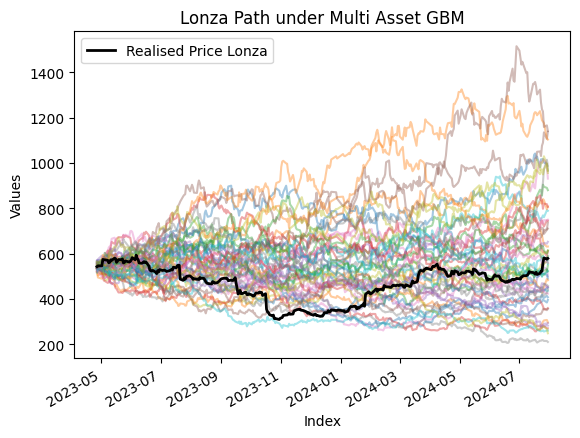

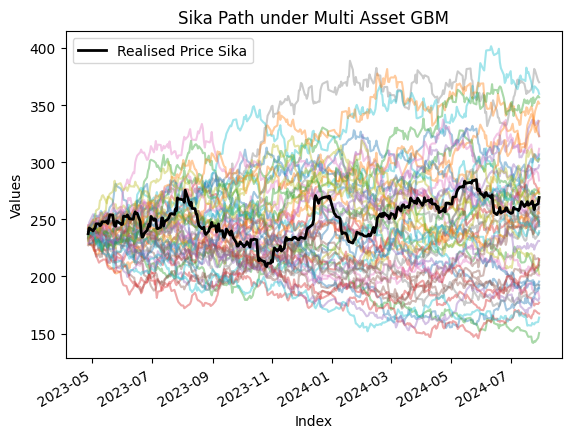

,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,...,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW
2023-04-27,531.958808,236.598072,542.421952,238.982766,547.161927,236.089531,547.386521,234.533952,568.105014,237.111327,...,545.772859,240.507638,523.270866,229.185274,557.243617,240.110096,546.827119,230.714358,516.329873,235.884873
2023-04-28,534.803126,242.953843,524.137169,241.277681,556.949588,236.587648,540.910988,229.686650,564.235494,240.182762,...,530.755508,237.084040,521.877323,231.142049,566.942323,243.861498,548.585324,239.525833,533.889694,238.170550
2023-05-02,517.588546,240.382113,535.692987,241.570219,539.445855,231.002373,539.783928,225.303756,559.725679,238.388190,...,522.845616,236.650088,496.817702,233.422004,558.141774,242.179917,557.218475,240.066593,527.342085,236.151549
2023-05-03,533.755244,243.991850,520.461887,241.985237,532.446921,227.334958,564.474361,222.311017,562.002905,234.999441,...,529.517910,239.135393,500.870700,235.509748,551.766054,242.637150,557.520804,245.477414,519.949990,238.670008
2023-05-04,556.536617,242.571327,515.788751,244.429087,536.351485,227.685602,567.176397,222.711784,569.571343,235.300230,...,544.297472,238.994065,489.444004,235.794249,566.624282,247.636161,549.927446,244.550618,540.477930,234.304702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24,1016.541996,192.403353,682.075214,336.664258,856.265923,270.448212,618.688507,177.457100,511.391495,334.021251,...,1237.279674,253.930964,745.784776,271.552477,411.141339,234.235705,272.726273,259.419931,497.246177,241.203343
2024-07-25,1017.926137,195.207465,658.168245,330.615935,904.522060,276.284891,606.749910,174.405376,534.258035,336.475582,...,1227.683259,257.637760,733.049210,266.491391,429.327565,235.270665,277.840895,262.151445,510.373980,241.624474
2024-07-26,1002.202788,192.486340,641.974419,326.232844,895.125955,276.152134,608.762657,175.979678,539.252843,332.447248,...,1159.454515,251.138729,747.805215,266.007144,416.017716,232.867674,276.815392,266.796605,509.485929,239.294557
2024-07-29,995.777818,193.312011,630.508315,334.216406,890.317251,274.035125,588.464081,175.808146,531.368740,336.467255,...,1166.082414,252.404186,747.039762,265.469591,425.114011,236.336920,266.961772,269.141660,518.737717,236.464720


In [6]:
sim_data_combined = multi_asset_gbm_n_sims(data = data, nsims = cs.n_sims, fdos = cs.initial_fixing_date, plot = False, plotasset=True)
sim_data_combined

In [7]:
lonza_path = sim_data_combined.iloc[:, ::2]
sika_path = sim_data_combined.iloc[:, 1::2]

In [10]:
lonza_path

,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,...,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW,LONN.SW
2023-04-27,531.958808,542.421952,547.161927,547.386521,568.105014,539.136925,534.086495,559.918836,531.726403,542.810960,...,551.503828,552.733816,542.989286,539.402988,532.421091,545.772859,523.270866,557.243617,546.827119,516.329873
2023-04-28,534.803126,524.137169,556.949588,540.910988,564.235494,532.124096,514.636998,553.808946,521.478765,545.668803,...,555.937137,559.398477,561.017263,536.111149,521.009135,530.755508,521.877323,566.942323,548.585324,533.889694
2023-05-02,517.588546,535.692987,539.445855,539.783928,559.725679,547.721252,508.279228,550.917608,508.301416,532.247363,...,546.489531,567.345564,567.786096,521.110104,540.743287,522.845616,496.817702,558.141774,557.218475,527.342085
2023-05-03,533.755244,520.461887,532.446921,564.474361,562.002905,542.677702,507.423620,531.041522,510.581947,550.296532,...,568.341703,594.300381,565.469860,499.424542,539.818564,529.517910,500.870700,551.766054,557.520804,519.949990
2023-05-04,556.536617,515.788751,536.351485,567.176397,569.571343,553.101981,512.227240,546.012251,509.849774,577.988585,...,533.019617,584.308109,538.752329,481.000128,580.420071,544.297472,489.444004,566.624282,549.927446,540.477930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24,1016.541996,682.075214,856.265923,618.688507,511.391495,708.641181,1001.144287,534.739071,595.086818,450.935019,...,418.685087,820.519295,581.978296,836.680109,278.761127,1237.279674,745.784776,411.141339,272.726273,497.246177
2024-07-25,1017.926137,658.168245,904.522060,606.749910,534.258035,712.155517,1012.249710,546.554426,592.783956,438.468052,...,407.501505,840.643464,573.293217,797.925341,284.410387,1227.683259,733.049210,429.327565,277.840895,510.373980
2024-07-26,1002.202788,641.974419,895.125955,608.762657,539.252843,687.216239,1015.206696,557.463419,604.787015,441.644175,...,404.526498,835.989889,580.742232,820.461297,289.981420,1159.454515,747.805215,416.017716,276.815392,509.485929
2024-07-29,995.777818,630.508315,890.317251,588.464081,531.368740,704.315842,993.740516,566.013543,604.282992,433.970765,...,413.217082,795.651605,577.397718,818.442866,291.263180,1166.082414,747.039762,425.114011,266.961772,518.737717


In [8]:
lonza = lonza_path.iloc[:,2]
sika = sika_path.iloc[:, 2]

In [9]:
lonza

2023-04-27    547.161927
2023-04-28    556.949588
2023-05-02    539.445855
2023-05-03    532.446921
2023-05-04    536.351485
                 ...    
2024-07-24    856.265923
2024-07-25    904.522060
2024-07-26    895.125955
2024-07-29    890.317251
2024-07-30    880.122778
Name: LONN.SW, Length: 315, dtype: float64